In [1]:
import pandas as pd
from time import time
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
import re
from collections import namedtuple, Counter
from sklearn.manifold import TSNE, MDS, Isomap
tsne=TSNE(metric='cosine')
mds=MDS()
iso=Isomap()
from ast import literal_eval

from sklearn.cluster import DBSCAN
dbscan=DBSCAN()


import seaborn as sns
import numpy as np
import random
import json

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ionab\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Training a lyric2vec model

Our first method uses a technique called word2vec. Word2vec is a word embedding technique created by Google which maps words in a given training corpus to vectors in a high-dimensional vector space (target dimension is user-defined). The aim is to embed words that are similar in a conceptual sense to vectors that are mathematically close to eachother in the resulting space. For example, "car" and "truck" would be close to eachother, but each far away from "banana". It also represents analogies: "king" - "man" + "woman" = "queen". This model is implemented as a part of gensim (https://radimrehurek.com/gensim/models/doc2vec.html).

## Import Dataset

In [2]:
song_df=pd.read_csv("../Data/songdata_clean.csv",sep=',',encoding='utf-8')
song_df.rename(columns={'Unnamed: 0' : 'index'}, inplace=True)
song_df.set_index('index',inplace=True)
song_df.sort_index(inplace=True)
print(len(song_df))
song_df.head()

56148


,language,artist,link,song,lyrics,release_date,album,genre,song_length
index,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198


## Run Doc2Vec

Or skip to loading model if one already exists...

In [3]:
song_df['label']=['"' + row['song'] + '" by ' + row['artist'] for i,row in song_df.iterrows()]
print(len(song_df))
song_df.head()

56148


,language,artist,link,song,lyrics,release_date,album,genre,song_length,label
index,,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153,"""She's My Kind Of Girl"" by ABBA"
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260,"""Andante, Andante"" by ABBA"
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312,"""As Good As New"" by ABBA"
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200,"""Bang"" by ABBA"
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198,"""Bang-A-Boomerang"" by ABBA"


We first preprocess the lyrics which includes removing puctuation, extra whitespace, numbers and stopwords (common words that don't add meaning such as "a", "the", "it",...). Although it is also common to stem words (keep only the root of the word), we will not do so in this case since we would like to distinguish between slang terms.

In [4]:
start=time()

CUSTOM_FILTERS = [lambda x: x.lower(), 
                  strip_tags, 
                  strip_punctuation, 
                  strip_multiple_whitespaces, 
                  strip_numeric, 
                  remove_stopwords, 
                  strip_short]

song_df['tokens']=[[]]*len(song_df)
docs = []
for i, row in song_df.iterrows():
    words = preprocess_string(row['lyrics'], filters=CUSTOM_FILTERS)
    song_df.at[i,'tokens'] = words
    tags = [str(i)]
    docs.append(TaggedDocument(words,tags))
    
print(time()-start)

22.042287826538086


Create training set

It is possible to train on a smaller dataset depending on the available computing power. However, I am able to train on the whole dataset in a reasonable amount of time.

In [5]:
#train_corpus=random.sample(docs,10000)
train_corpus=docs

This is what a "document" looks like after preprocessing. These are the words from which the vectors will be calculated.

In [6]:
train_corpus[0]

TaggedDocument(words=['look', 'face', 'wonderful', 'face', 'means', 'special', 'look', 'way', 'smiles', 'sees', 'lucky', 'fellow', 'kind', 'girl', 'makes', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leaves', 'walk', 'park', 'holds', 'squeezes', 'hand', 'walking', 'hours', 'talking', 'things', 'plan', 'kind', 'girl', 'makes', 'feel', 'fine', 'believe', 'kind', 'girl', 'blue', 'leaves'], tags=['0'])

Run model

Here, we train a word2vec model on our dataset

In [7]:
model = Doc2Vec(vector_size=100, min_count=2, workers=4, epochs=20)

model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 1min 23s


We save the model to avoid having to rerun it in the future.

In [8]:
model.save("../Data/doc2vec100.model")

Example:

To demonstrate the word2vec model, we show words that the model thinks are similar to the term 'anger'. This model is more than just bag-of-words. We now have the ability to identify concepts.

In [9]:
model.similar_by_word('anger')

C:\Users\ionab\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).



[('rage', 0.6911046504974365),
 ('fear', 0.6525371074676514),
 ('pain', 0.5867269039154053),
 ('silence', 0.5725931525230408),
 ('violence', 0.5237935781478882),
 ('emptiness', 0.5214130878448486),
 ('darkness', 0.5206449031829834),
 ('hate', 0.5120272040367126),
 ('sorrow', 0.494174599647522),
 ('damage', 0.4939436614513397)]

## Use model to predict vectors for each song

We can now perform what is called doc2vec. This embeds documents (in our case, lyrics) into the word vector space such that each document is the average of its word vectors. This way, we are able to maintain the relationship between conceptual similarity and distance. Lyrics that speak of similar things should be close to each-other in the vector space. 

In [7]:
#load model
model = Doc2Vec.load("../Data/doc2vec100.model")

model.docvecs['0']  # example vector

array([-0.1552842 ,  0.32124212, -0.10973388,  0.398913  , -0.21181993,
        0.34487513, -0.05668425, -0.00405348, -0.37425393, -0.29330194,
       -0.08731837, -0.1026438 ,  0.62745202,  0.04975977,  0.09621581,
        0.50583023,  0.21911868,  0.73633379, -0.43037924,  0.1088292 ,
        0.09072801,  1.03575397,  0.01924993, -0.1882364 ,  0.66964322,
       -0.26454499,  0.50654155,  0.27219662, -0.47667563, -0.40025991,
        0.28912491, -0.20896839, -0.54846454,  0.41333973,  0.22351155,
        0.19965161,  0.0660124 ,  0.37837461,  0.40947029, -0.19151177,
       -0.12478214, -0.40382242, -0.73411083, -0.31007615, -0.51365167,
        0.14354078,  0.19070281,  0.43546233, -0.15626371, -0.06785101,
       -0.31640771,  0.21533652,  0.07571842,  0.07280903,  0.15747148,
       -0.29432711, -0.02797395,  0.78902829,  0.15773904,  0.15609123,
       -0.44292244, -0.09109776, -0.28745377,  0.0965297 , -0.04653584,
        1.00307906,  0.10432844, -0.17493297,  0.10374723,  0.01

For each row of our data we enter the vector calculated by the model.

In [11]:
start=time()

song_df['vec100']=[list()]*len(song_df)

for i,row in song_df.iterrows():
    try:
        song_df.at[i,'vec100'] = model.docvecs[str(i)]
    except:
        song_df.at[i,'vec100'] = model.infer_vector(row['tokens'])
    
        
song_df=song_df[song_df['vec100'].astype(str) != '[]']

print(time()-start)
print(len(song_df))
song_df.head()

87.31954026222229
56148


,language,artist,link,song,lyrics,release_date,album,genre,song_length,label,tokens,vec100
index,,,,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153,"""She's My Kind Of Girl"" by ABBA","[look, face, wonderful, face, means, special, ...","[-0.155284, 0.321242, -0.109734, 0.398913, -0...."
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260,"""Andante, Andante"" by ABBA","[easy, touch, gently, like, summer, evening, b...","[-0.495835, 0.0695689, 0.105216, 0.0640798, -0..."
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312,"""As Good As New"" by ABBA","[know, lousy, rotten, boy, tough, packing, stu...","[0.275225, 0.138312, 0.13923, 0.536003, -0.212..."
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200,"""Bang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.509531, -0.264079, 0.925212, 0.100037, 0.2..."
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198,"""Bang-A-Boomerang"" by ABBA","[making, somebody, happy, question, learn, com...","[-0.680009, -0.225331, 0.676759, 0.0841594, 0...."


Save vectors

In [12]:
#song_df['vec100'].astype(str, inplace=True)
song_df.to_csv('../Data/song_vecs100.csv',sep=',',encoding='utf-8')

## Visualise Embedding

In [8]:
song_df=pd.read_csv('../Data/song_vecs100.csv',sep=',',encoding='utf-8')
song_df.set_index('index',inplace=True)
song_df['vec100']=[[float(y) for y in x[1:-1].split()] for x in song_df.vec100]
song_df.head()

,language,artist,link,song,lyrics,release_date,album,genre,song_length,label,tokens,vec100
index,,,,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153,"""She's My Kind Of Girl"" by ABBA","['look', 'face', 'wonderful', 'face', 'means',...","[-0.1552842, 0.32124212, -0.10973388, 0.398913..."
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260,"""Andante, Andante"" by ABBA","['easy', 'touch', 'gently', 'like', 'summer', ...","[-0.49583471, 0.06956885, 0.10521561, 0.064079..."
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312,"""As Good As New"" by ABBA","['know', 'lousy', 'rotten', 'boy', 'tough', 'p...","[0.27522475, 0.13831177, 0.1392298, 0.53600252..."
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200,"""Bang"" by ABBA","['making', 'somebody', 'happy', 'question', 'l...","[-0.5095306, -0.26407892, 0.92521173, 0.100037..."
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198,"""Bang-A-Boomerang"" by ABBA","['making', 'somebody', 'happy', 'question', 'l...","[-0.68000865, -0.22533123, 0.67675865, 0.08415..."


Reduce dimensions

In [9]:
song_sample=song_df.query("genre==genre").sample(5000)

%time vec2D=tsne.fit_transform(song_sample.vec100.tolist())

song_sample['x']=[x[0] for x in vec2D]
song_sample['y']=[x[1] for x in vec2D]

song_sample.head()

Wall time: 2min 32s


,language,artist,link,song,lyrics,release_date,album,genre,song_length,label,tokens,vec100,x,y
index,,,,,,,,,,,,,,
3993,NaN,Deep Purple,/d/deep+purple/might+just+take+your+life_20038...,Might Just Take Your Life,"I got more than I asked for, \r\r\r\r\r\r\r\r...",1974.0,Burn,Rock,242,"""Might Just Take Your Life"" by Deep Purple","['got', 'asked', 'ain', 'nothin', 'need', 'too...","[0.86137837, 0.490565, 0.80306441, 0.73454988,...",38.218449,7.087102
40317,en,Lenny Kravitz,/l/lenny+kravitz/for+the+first+time_20082684.html,For The First Time,I want to fall in love again \r\r\r\r\r\r\r\r...,1993.0,Are You Gonna Go My Way,Rock,111,"""For The First Time"" by Lenny Kravitz","['want', 'fall', 'love', 'time', 'makes', 'kin...","[-0.18832991, 0.00377371, -0.12170465, 0.15395...",-0.426918,-2.014256
10171,NaN,Leann Rimes,/l/leann+rimes/good+friends+and+a+glass+of+win...,Good Friends And A Glass Of Wine,I need a good friend \r\r\r\r\r\r\r\r\r\r\r\r...,2007.0,Family,Country,336,"""Good Friends And A Glass Of Wine"" by Leann Rimes","['need', 'good', 'friend', 'died', 'crowned', ...","[-0.79973727, 0.34404427, -0.02796731, -0.1739...",-4.856460,19.578217
7224,NaN,Incubus,/i/incubus/earth+to+bella_20576184.html,Earth To Bella,Earth to Bella \r\r\r\r\r\r\r\r\r\r\r\r\r\r\r...,2006.0,Light Grenades,Rock,157,"""Earth To Bella"" by Incubus","['earth', 'bella', 'think', 'got', 'figured', ...","[0.19630273, 0.25312781, -0.53943205, -0.66944...",2.960724,-16.134850
44280,en,Neil Young,/n/neil+young/berlin_20818803.html,Berlin,Just like a young boy \r\r\r\r\r\r\r\r\r\r\r\...,NaN,NaN,Rock,254,"""Berlin"" by Neil Young","['like', 'young', 'boy', 'running', 'road', 's...","[-0.0996438, -0.11298982, 0.57749552, 0.936936...",-1.889143,38.466709


2D representation of dataset

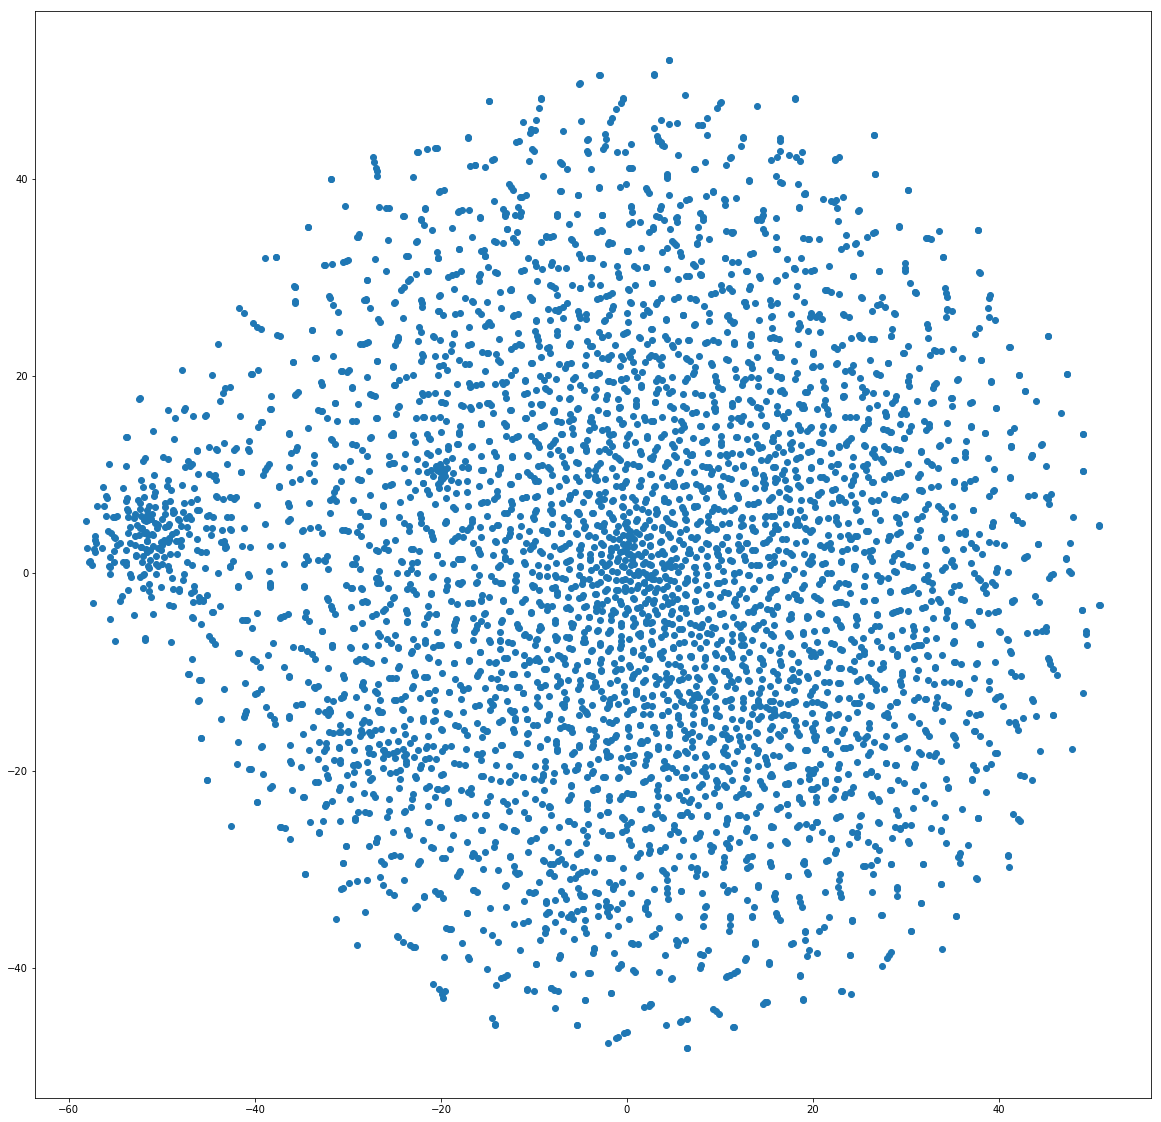

In [6]:
plt.figure(figsize=(20,20))
plt.plot(song_sample['x'],song_sample['y'], 'o')
plt.savefig('../Figures/lyric2vec.pdf')

### Visualise by Song Genres
Although high-dimensional data does not cluster very well, we can see if songs of the same genre are close to eachother.

In [35]:
palette=sns.color_palette("hls", len(set(song_sample.genre)))
genres=sorted(list(set(song_sample.genre)))
data=[]
for i,genre in enumerate(genres):
    temp=song_sample[song_sample["genre"] == genre]
    trace = go.Scatter(
                x = temp.x,
                y = temp.y,
                text = temp.label,
                hoverinfo = 'text',
                mode = 'markers',
                marker = {'color': 'rgb{}'.format(palette[i])},
                name = genre
            )
    
    data.append(trace)

layout=go.Layout(
    width=1000,
    height=1000,
    hovermode='closest')

iplot(go.Figure(data=data, layout=layout), filename='lyric2vec_bygenre', image='png')

We find that Rap is the only genre which seems to cluster. This indicates that rap has a distinctive vocabulary. Since doc2vec embeds documents based on vocabulary, documents that have a very disticive vocabulary tend to cluster. For example, given a multilingual corpus, this often produces language clusters.

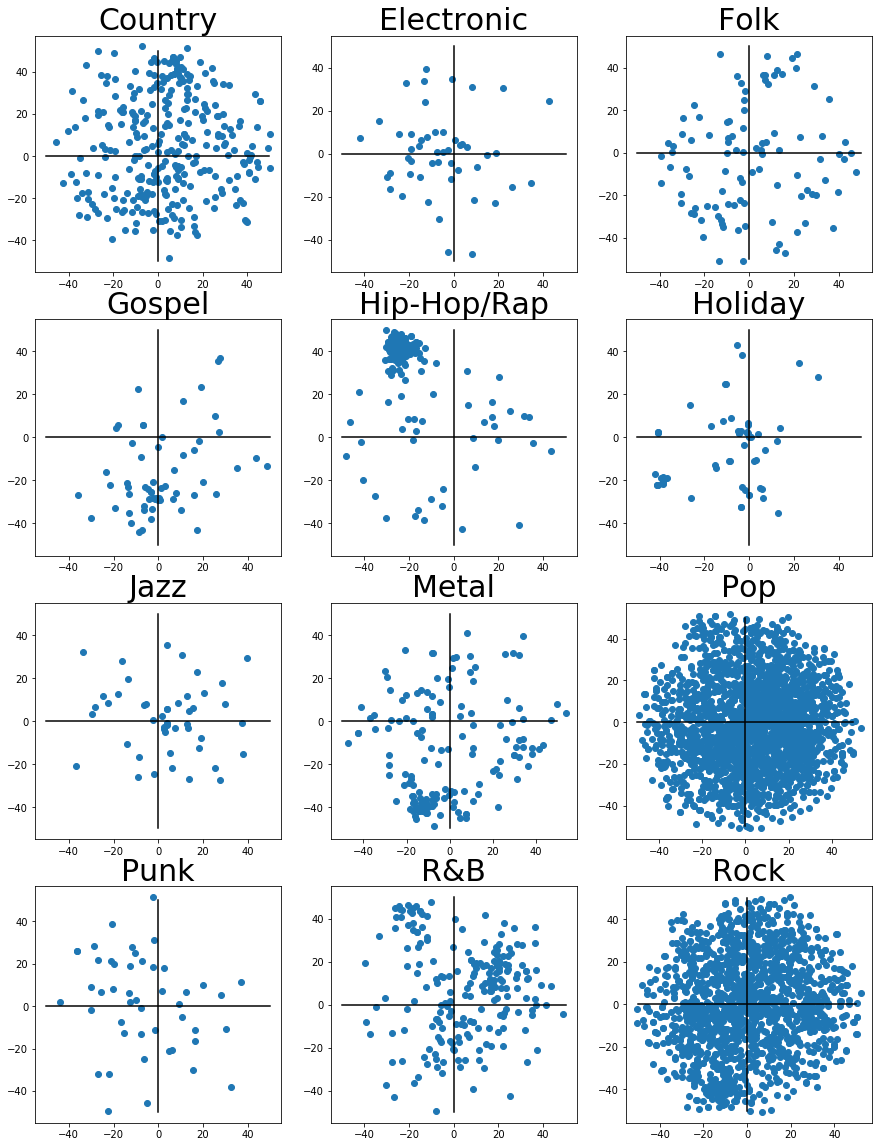

In [43]:
genres=[
 'Country',
 'Electronic',
 'Folk',
 'Gospel',
 'Hip-Hop/Rap',
 'Holiday',
 'Jazz',
 'Metal',
 'Pop',
 'Punk',
 'R&B',
 'Rock']

plt.subplots(figsize=(15,20))
for i,genre in enumerate(genres):
    plt.subplot(4,3,i+1)
    temp=song_sample[song_sample["genre"] == genre]
    plt.title(genre, fontdict={'fontsize': 30})
    plt.plot(temp.x, temp.y, 'o')
    plt.plot([-50,50],[0,0], c='black')
    plt.plot([0,0],[-50,50], c='black')
    
plt.savefig('../Figures/lyric2vec_bygenre_separate.pdf')
plt.show()